#### 1

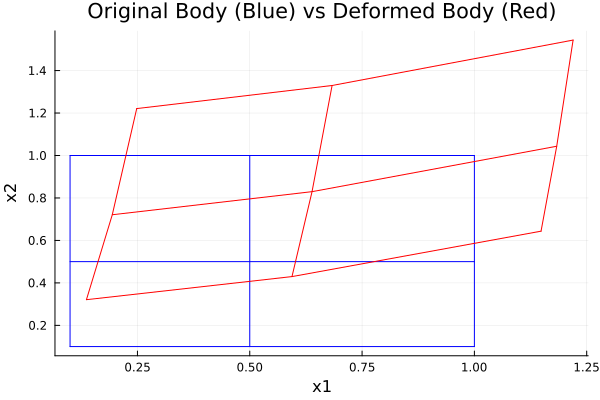

In [2]:
using Plots

# 1. Define a coarse original grid (only 3×3 points)
x1_range = [0.1, 0.5, 1.0]   
x2_range = [0.1, 0.5, 1.0]   
# Original grid (matrices)
X1 = [x1 for x2 in x2_range, x1 in x1_range]
X2 = [x2 for x2 in x2_range, x1 in x1_range]

# Displacement field
u1 = @. 0.2 * log(1 + X1 + X2)
u2 = @. 0.2 * exp(X1)

# Deformed coordinates
x1_new = X1 .+ u1
x2_new = X2 .+ u2

# Plot original body (blue)
plot(title="Original Body (Blue) vs Deformed Body (Red)",
     xlabel="x1", ylabel="x2", legend=false)

# horizontal & vertical lines – ORIGINAL
for i in eachindex(x2_range)
    plot!(X1[i, :], X2[i, :], color=:blue)   # horizontal
end
for j in eachindex(x1_range)
    plot!(X1[:, j], X2[:, j], color=:blue)   # vertical
end

# horizontal & vertical lines – DEFORMED
for i in eachindex(x2_range)
    plot!(x1_new[i, :], x2_new[i, :], color=:red)
end
for j in eachindex(x1_range)
    plot!(x1_new[:, j], x2_new[:, j], color=:red)
end

display(plot!())


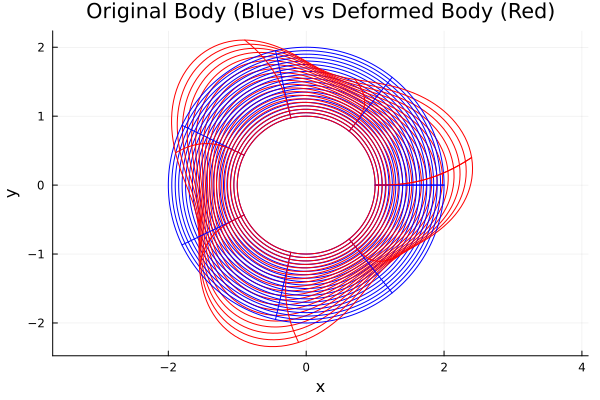

In [5]:
using Plots

# Radii for circular layers and for radial lines
R_circles = 1.0:0.05:2.0            # many circles
R_radial  = 1.0:0.05:2.0            # points along each radial line

Theta_circle = range(0, 2π, length=200)   # smooth circles
Theta_radial = range(0, 2π, length=8)    # only 12 radial lines

plot(title="Original Body (Blue) vs Deformed Body (Red)",
     xlabel="x", ylabel="y",
     aspect_ratio=:equal, legend=false)

# ---- Circles: constant r ----
for r in R_circles
    θ = Theta_circle

    # original
    X1 = r .* cos.(θ)
    X2 = r .* sin.(θ)

    # displacement in polar
    u_r     = 0.4 .* (r .- 1).^2 .* cos.(3 .* θ)
    u_theta = 0.4 .* (r .- 1).^3 .* ones(length(θ))

    # to Cartesian
    u1 = u_r .* cos.(θ) .- u_theta .* sin.(θ)
    u2 = u_r .* sin.(θ) .+ u_theta .* cos.(θ)

    x1_new = X1 .+ u1
    x2_new = X2 .+ u2

    plot!(X1, X2, color=:blue)   # original circle
    plot!(x1_new, x2_new, color=:red)  # deformed circle
end

# ---- Radial lines: constant θ ----
for θ in Theta_radial
    r = collect(R_radial)

    # original
    X1 = r .* cos(θ)
    X2 = r .* sin(θ)

    # displacement in polar
    u_r     = 0.4 .* (r .- 1).^2 .* cos(3 * θ)
    u_theta = 0.4 .* (r .- 1).^3

    # to Cartesian
    u1 = u_r .* cos(θ) .- u_theta .* sin(θ)
    u2 = u_r .* sin(θ) .+ u_theta .* cos(θ)

    x1_new = X1 .+ u1
    x2_new = X2 .+ u2

    plot!(X1, X2, color=:blue)   # original radial line
    plot!(x1_new, x2_new, color=:red)  # deformed radial line
end

display(plot!())


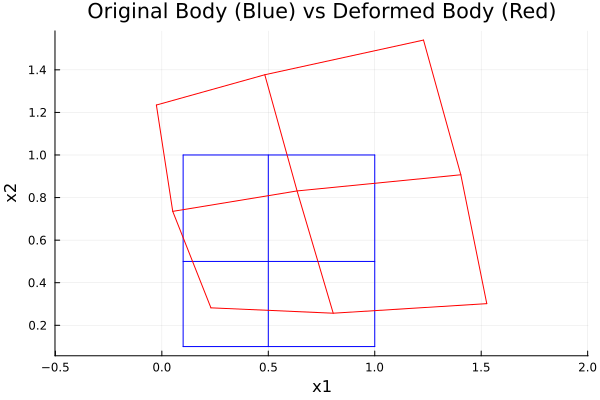

In [6]:
using Plots

# --- 1. Coarse rectangular grid ---
x1_range = [0.1, 0.5, 1.0]   # left, middle, right
x2_range = [0.1, 0.5, 1.0]   # bottom, middle, top

# Create original grid as matrices
X1 = [x1 for x2 in x2_range, x1 in x1_range]
X2 = [x2 for x2 in x2_range, x1 in x1_range]

# --- 2. Compute displacements on the grid (your mixed basis) ---

# Local polar parameters
R     = @. sqrt(X1^2 + X2^2)
theta = @. atan(X2, X1)

# Given displacements in polar basis
u_r     = @. 0.2 * exp(X1)
u_theta = @. 0.2 * log(1 + X1 + X2)

# Convert to Cartesian components
u1 = @. u_r * cos(theta) - u_theta * sin(theta)
u2 = @. u_r * sin(theta) + u_theta * cos(theta)

# Deformed coordinates
x1_new = X1 .+ u1
x2_new = X2 .+ u2

# --- 3. Plot original vs deformed grids as lines ---

plt = plot(title="Original Body (Blue) vs Deformed Body (Red)",
           xlabel="x1", ylabel="x2",
           legend=false, aspect_ratio=:equal)

# Original grid (blue)
for i in eachindex(x2_range)          # horizontal lines
    plot!(plt, X1[i, :], X2[i, :], color=:blue)
end
for j in eachindex(x1_range)          # vertical lines
    plot!(plt, X1[:, j], X2[:, j], color=:blue)
end

# Deformed grid (red)
for i in eachindex(x2_range)
    plot!(plt, x1_new[i, :], x2_new[i, :], color=:red)
end
for j in eachindex(x1_range)
    plot!(plt, x1_new[:, j], x2_new[:, j], color=:red)
end

display(plt)


In [7]:
import Gmsh: gmsh

# Initializing Gmsh
gmsh.initialize()

gmsh.model.add("PlateHole")

# --- Parameters (Converted to Meters to match your L=1 scale) ---
L = 1.0      # 1000 mm
H = 0.4      # 400 mm
R = 0.075    # Radius 75 mm
Xc = 0.5     # Center X (500 mm)
Yc = 0.2     # Center Y (200 mm)

# Mesh sizes
h_coarse = 0.05  # Coarse mesh for far boundaries
h_fine   = 0.005 # Fine mesh for the hole (CRITICAL for stress concentration)

# --- 1. Define the Outer Rectangle ---
p1 = gmsh.model.geo.addPoint(0, 0, 0, h_coarse)
p2 = gmsh.model.geo.addPoint(L, 0, 0, h_coarse)
p3 = gmsh.model.geo.addPoint(L, H, 0, h_coarse)
p4 = gmsh.model.geo.addPoint(0, H, 0, h_coarse)

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

# Outer Loop
cl_rect = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

# --- 2. Define the Inner Circle ---
# We create 5 points: Center + 4 points on the circumference (Top, Right, Bottom, Left)
# This method (Circle Arcs) is more robust for meshing than a single full circle.

pc = gmsh.model.geo.addPoint(Xc, Yc, 0, h_fine) # Center
p_r = gmsh.model.geo.addPoint(Xc + R, Yc, 0, h_fine)
p_t = gmsh.model.geo.addPoint(Xc, Yc + R, 0, h_fine)
p_l = gmsh.model.geo.addPoint(Xc - R, Yc, 0, h_fine)
p_b = gmsh.model.geo.addPoint(Xc, Yc - R, 0, h_fine)

# Create 4 arcs to form the circle
c1 = gmsh.model.geo.addCircleArc(p_r, pc, p_t)
c2 = gmsh.model.geo.addCircleArc(p_t, pc, p_l)
c3 = gmsh.model.geo.addCircleArc(p_l, pc, p_b)
c4 = gmsh.model.geo.addCircleArc(p_b, pc, p_r)

# Inner Loop
cl_hole = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4])

# --- 3. Create Surface with Hole ---
# The first loop is the boundary, subsequent loops are holes
s = gmsh.model.geo.addPlaneSurface([cl_rect, cl_hole])

# --- 4. Physical Groups (Boundary Conditions) ---
# Domain
gmsh.model.addPhysicalGroup(2, [s], 1, "Plate")

# Boundaries
gmsh.model.addPhysicalGroup(1, [l4], 2, "FixedLeft")  # Left Edge
gmsh.model.addPhysicalGroup(1, [l2], 3, "LoadRight")  # Right Edge
gmsh.model.addPhysicalGroup(1, [c1, c2, c3, c4], 4, "HoleEdge") # Hole boundary

# Synchronize and Mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

# Write mesh to file
gmsh.write("PlateHole.msh")

# Launch GUI to see the result
gmsh.fltk.run()
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00606489s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.025826s, CPU 0.015625s)
Info    : 766 nodes 1539 elements
Info    : Writing 'PlateHole.msh'...
Info    : Done writing 'PlateHole.msh'
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hx

## 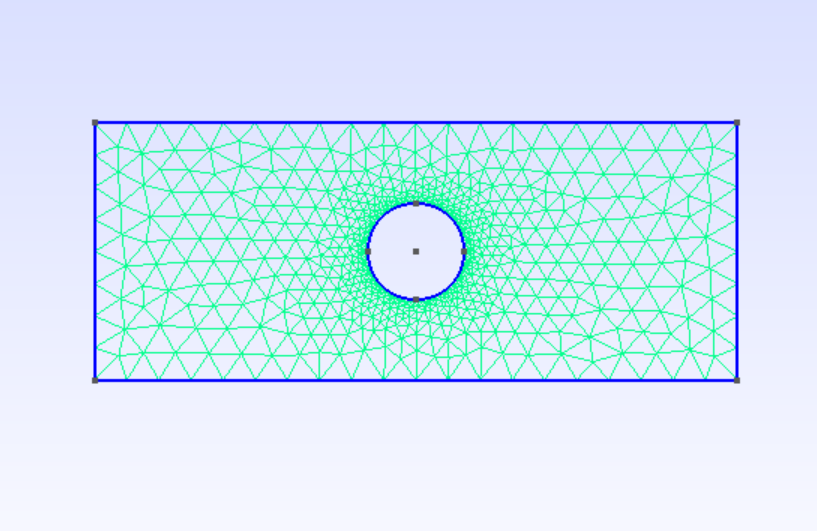

In [13]:
using Gridap
using GridapGmsh
using LinearAlgebra # Required for tr() and dot products

# 1. Read the Mesh
model = GmshDiscreteModel("PlateHole.msh")

# 2. Material Parameters (Steel)
const E = 210000.0  # MPa
const ν = 0.3       # Poisson's ratio
const thickness = 2.0 # mm

# Lamé parameters for Plane Stress
const μ = E / (2 * (1 + ν))
const λ = (E * ν) / ((1 + ν) * (1 - 2 * ν))
const λ_ps = (2 * λ * μ) / (λ + 2 * μ) # Plane stress correction

# Pre-define Identity Tensor for 2D
# We use TensorValue(xx, xy, yx, yy) instead of SymTensorValue to avoid import errors
const I = TensorValue(1.0, 0.0, 0.0, 1.0)

# Constitutive Law: σ = C : ε
function σ(ε)
    return λ_ps * tr(ε) * I + 2 * μ * ε
end

# 3. Define FE Spaces
reffe = ReferenceFE(lagrangian, VectorValue{2, Float64}, 1)
V = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags="FixedLeft")
U = TrialFESpace(V, VectorValue(0.0, 0.0)) 

# 4. Numerical Integration
degree = 2
Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

Γ = BoundaryTriangulation(model, tags="LoadRight")
dΓ = Measure(Γ, degree)

# 5. Define Weak Form
# Traction: 50 MPa in X direction
t_vec = VectorValue(50.0, 0.0)

# Internal Work (Stiffness)
a(u, v) = ∫( ε(v) ⊙ (σ ∘ ε(u)) ) * dΩ

# External Work (Load)
l(v) = ∫( v ⋅ t_vec ) * dΓ

# 6. Solve
op = AffineFEOperator(a, l, U, V)
uh = solve(op)

# 7. Post-Process
writevtk(Ω, "results_PlateHole", cellfields=["Displacement" => uh, "Stress" => σ ∘ ε(uh)])

println("Analysis Complete! Open 'results_PlateHole.vtu' in Paraview.")

Info    : Reading 'PlateHole.msh'...
Info    : 18 entities
Info    : 765 nodes
Info    : 1490 elements
Info    : Done reading 'PlateHole.msh'
Analysis Complete! Open 'results_PlateHole.vtu' in Paraview.


In [14]:
writevtk(Ω, "results_PlateHole", cellfields=["Displacement" => uh, "Stress" => σ ∘ ε(uh)])

(["results_PlateHole.vtu"],)

# 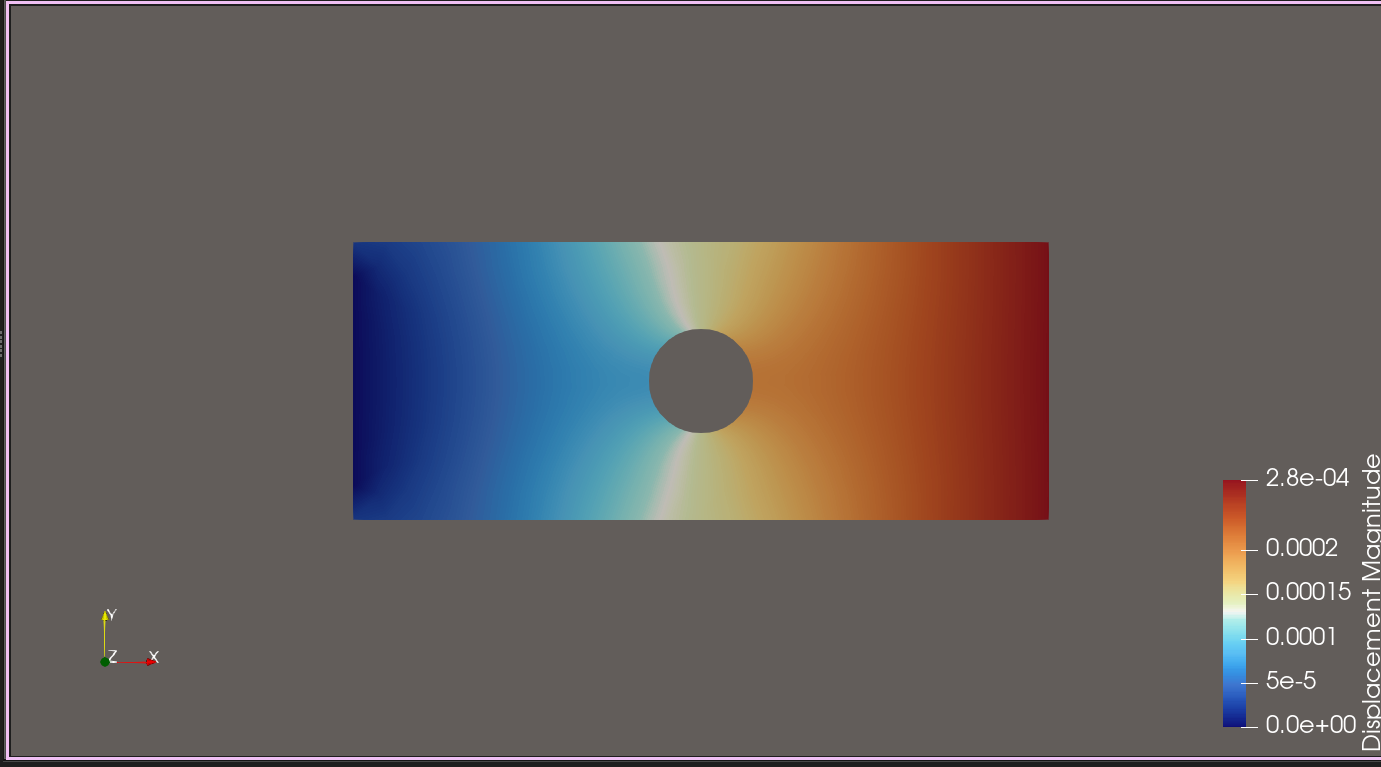

In [15]:
using Gmsh
using Gridap
using GridapGmsh
using LinearAlgebra

# ==========================================
# PART 1: MESH GENERATION
# ==========================================
function generate_mesh()
    mesh_file = "cantilever_q5.msh"
    
    # 1. Force cleanup of old files
    if isfile(mesh_file)
        rm(mesh_file)
        println("Deleted old mesh file to ensure clean generation.")
    end

    # 2. Initialize Gmsh
    if gmsh.isInitialized() == 1
        gmsh.finalize()
    end
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("Cantilever_Patch")

    # 3. Geometry Parameters
    L = 1000.0
    H = 200.0
    W = 250.0
    PatchRadius = 5.0 # 5mm radius patch

    # 4. Create Geometry
    println("Generating geometry...")
    
    # A. Beam Box
    beam_tag = gmsh.model.occ.addBox(0, 0, 0, L, H, W)
    
    # B. Load Patch Disk
    # Created at (L, H/2, W/2). By default, addDisk is in the XY plane (Normal Z).
    disk_tag = gmsh.model.occ.addDisk(L, H/2.0, W/2.0, PatchRadius, PatchRadius)
    
    # CRITICAL FIX: Rotate the disk 90 degrees (pi/2) around the Y-axis.
    # This aligns its normal from Z (0,0,1) to X (1,0,0), matching the beam face.
    # Center of rotation: (L, H/2, W/2)
    gmsh.model.occ.rotate([(2, disk_tag)], L, H/2.0, W/2.0, 0, 1, 0, pi/2)
    
    # C. Fragment (Imprint disk onto beam)
    # This merges the aligned disk into the beam face.
    gmsh.model.occ.fragment([(3, beam_tag)], [(2, disk_tag)])
    gmsh.model.occ.synchronize()

    # 5. Physical Groups
    
    # A. Fixed End (X=0)
    fixed_surfaces = gmsh.model.getEntitiesInBoundingBox(-0.1, -0.1, -0.1, 0.1, H+0.1, W+0.1, 2)
    if isempty(fixed_surfaces)
        error("Generation Failed: Fixed end not found.")
    end
    gmsh.model.addPhysicalGroup(2, [e[2] for e in fixed_surfaces], 1, "fixedEnd")
    gmsh.model.setPhysicalName(2, 1, "fixedEnd")

    # B. Load Patch (X=L, Center)
    # Because we rotated the disk, it now lies flat on X=L.
    # We search for the surface strictly inside the patch area to distinguish it from the rest of the face.
    tol = 0.1 
    load_surfaces = gmsh.model.getEntitiesInBoundingBox(
        L-0.1, H/2.0 - PatchRadius - tol, W/2.0 - PatchRadius - tol,
        L+0.1, H/2.0 + PatchRadius + tol, W/2.0 + PatchRadius + tol, 2
    )
    
    if isempty(load_surfaces)
        # Fallback debug if specific bound check fails
        error("Generation Failed: Load patch surface not found. The boolean fragment might have failed.")
    else
        println("Load Patch Surface Found: ", [e[2] for e in load_surfaces])
    end
    
    gmsh.model.addPhysicalGroup(2, [e[2] for e in load_surfaces], 2, "loadPatch")
    gmsh.model.setPhysicalName(2, 2, "loadPatch")

    # C. Beam Volume
    vol_tags = [e[2] for e in gmsh.model.getEntities(3)]
    gmsh.model.addPhysicalGroup(3, vol_tags, 3, "beam")
    gmsh.model.setPhysicalName(3, 3, "beam")

    # 6. Mesh Settings
    # Refine on patch
    gmsh.model.mesh.setSize(gmsh.model.getBoundary(load_surfaces, false, false, true), 5.0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 25)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 50)

    # 7. Generate and Write
    gmsh.model.mesh.generate(3)
    gmsh.write(mesh_file)
    gmsh.finalize()
    println("SUCCESS: New mesh generated at $mesh_file")
end

# ==========================================
# PART 2: FEM SOLVER
# ==========================================
function solve_fem()
    mesh_file = "cantilever_q5.msh"
    # mesh_file = "CantileverBeam.msh"
    if !isfile(mesh_file)
        error("Mesh file missing despite generation attempt.")
    end

    println("\nLoading mesh into Gridap...")
    model = GmshDiscreteModel(mesh_file)

    # Verify Tags
    labels = get_face_labeling(model)
    tags = labels.tag_to_name
    println("Tags detected in mesh: ", tags)
    if !("loadPatch" in tags)
        error("CRITICAL: 'loadPatch' tag still missing.")
    end

    # Material
    E = 25000.0; ν = 0.2
    λ = (E * ν) / ((1 + ν) * (1 - 2 * ν))
    μ = E / (2 * (1 + ν))
    σ(ε) = λ * tr(ε) * one(ε) + 2 * μ * ε

    # FE Spaces
    reffe = ReferenceFE(lagrangian, VectorValue{3, Float64}, 1)
    V = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags="fixedEnd")
    U = TrialFESpace(V, VectorValue(0.0, 0.0, 0.0))

    # Measures
    Ω = Triangulation(model)
    dΩ = Measure(Ω, 2)
    Γ_load = BoundaryTriangulation(model, tags="loadPatch")
    dΓ_load = Measure(Γ_load, 2)

    # Distributed Load Calculation
    force_total = 1000.0 # N
    patch_radius = 5.0
    patch_area = π * patch_radius^2
    traction_val = force_total / patch_area
    traction = VectorValue(0.0, -traction_val, 0.0) # Downwards

    println("Applying Traction: $traction_val N/mm^2 on patch.")

    # Solver
    a(u, v) = ∫( ε(v) ⊙ (σ ∘ ε(u)) )dΩ
    l(v) = ∫( v ⋅ traction )dΓ_load

    println("Solving system...")
    op = AffineFEOperator(a, l, U, V)
    uh = solve(op)
    println("Solution Found.")

    # Export
    σ_h = σ ∘ ε(uh)
    
    # Manual Von Mises function
    function vm_manual(σ_t)
        s = σ_t - (tr(σ_t)/3)*one(σ_t)
        return sqrt(1.5 * (s ⊙ s))
    end

    output_file = "cantilever_q5_solution"
    # output_file = "cantilever_solution"
    writevtk(Ω, output_file, cellfields=[
        "Displacement" => uh,
        "Strain" => ε(uh),
        "Stress" => σ_h,
        "VonMises" => vm_manual ∘ σ_h
    ])
    println("Results saved to $output_file.vtu")
end

# ==========================================
# EXECUTION
# ==========================================
generate_mesh()
solve_fem()

Generating geometry...
Load Patch Surface Found: Int32[7]ting solids                                                                                                 
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 13 (Ellipse)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 70%] Meshing curve 21 (Line)
Info    : [ 70%] Meshing curve 22 (Line)
Info    : [ 80%] Meshing curve 23 (Line)
Info    : [ 90%] Meshing curve 24 (Line)
Info    : [100%] Meshing curve 25 (Line)
Info    : Done meshing 1D (Wall 0.00314808s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 8 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 9 (Plane, Frontal-Delaunay)
Info    : [ 50

# 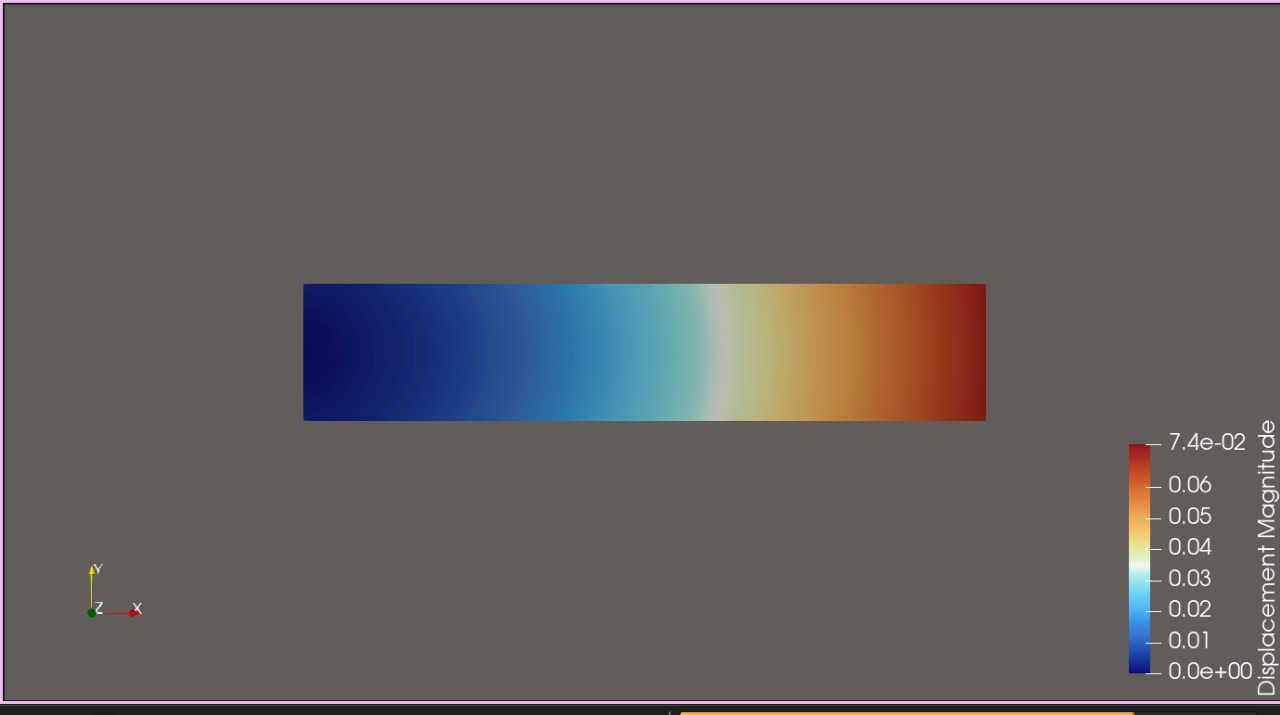

In [9]:
using Gmsh

# Initialize Gmsh
gmsh.initialize()

# --- 1. Define Geometry Parameters ---
# Based on Question 6:
# Length = 1000 mm
# Cross-section = 250 mm (Width) x 200 mm (Height)
# Load is on the "Top Surface"
L = 1000.0
H = 200.0
W = 250.0

# --- 2. Create Geometry (OpenCASCADE Kernel) ---
# We create a box with corner at (0,0,0)
# Dimensions: dx=L, dy=H, dz=W
# Alignment:
# X-axis: Length (0 to 1000)
# Y-axis: Height (0 to 200)
# Z-axis: Width  (0 to 250)

gmsh.model.occ.addBox(0, 0, 0, L, H, W, 1)

# Synchronize CAD with Gmsh model
gmsh.model.occ.synchronize()

# --- 3. Define Physical Groups ---
# This is crucial for Gridap to apply Boundary Conditions.
# We need to group the geometric entities (Surfaces/Volumes) and give them names.

# Helper function to find surfaces based on position
function get_surfaces_in_box(xmin, ymin, zmin, xmax, ymax, zmax)
    surfaces = gmsh.model.getEntities(2) # Get all surfaces (dim=2)
    selected_tags = Int[]
    
    for (dim, tag) in surfaces
        # Get bounding box of the surface
        bb = gmsh.model.getBoundingBox(dim, tag)
        # bb returns (xmin, ymin, zmin, xmax, ymax, zmax)
        
        # Check if the surface is approximately inside our target box (using a small tolerance)
        tol = 0.1
        if (bb[1] >= xmin - tol) && (bb[4] <= xmax + tol) &&
           (bb[2] >= ymin - tol) && (bb[5] <= ymax + tol) &&
           (bb[3] >= zmin - tol) && (bb[6] <= zmax + tol)
            push!(selected_tags, tag)
        end
    end
    return selected_tags
end

# A. The Beam Volume (for material properties)
# Get all volume entities (dim=3)
vol_tags = [t[2] for t in gmsh.model.getEntities(3)]
gmsh.model.addPhysicalGroup(3, vol_tags, 1, "beam")

# B. The Fixed End (Support)
# Located at X = 0. It is the face in the plane X=0.
# Bounding box for check: X:[0,0], Y:[0,H], Z:[0,W]
fixed_end_tags = get_surfaces_in_box(0, 0, 0, 0.1, H, W) 
gmsh.model.addPhysicalGroup(2, fixed_end_tags, 2, "fixedEnd")

# C. The Top Surface (Load Application)
# Located at Y = H (200). It is the face in the plane Y=200.
# Bounding box for check: X:[0,L], Y:[H,H], Z:[0,W]
top_surface_tags = get_surfaces_in_box(0, H-0.1, 0, L, H+0.1, W)
gmsh.model.addPhysicalGroup(2, top_surface_tags, 3, "topSurface")

# --- 4. Mesh Settings ---
# Set element size (Characteristic Length)
# Adjust Min/Max to control mesh fineness. 
# A value of ~30-50mm is coarse but fast; 10-20mm is finer.
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 25)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 50)

# --- 5. Generate and Save Mesh ---
gmsh.model.mesh.generate(3) # Generate 3D mesh

output_filename = "cantilever_q6.msh"
gmsh.write(output_filename)

println("Mesh generated successfully: $output_filename")

# Finalize Gmsh
gmsh.finalize()

# import Gmsh: gmsh

# # Initializing Gmsh
# gmsh.initialize()

# gmsh.model.add("CantileverBeam")

# # --- Parameters (Converted to Meters) ---
# L = 1.0      # Length 1000 mm
# W = 0.25     # Width 250 mm
# H = 0.20     # Height 200 mm

# # Mesh Size
# lc = 0.05    # Characteristic length

# # --- 1. Define the Cross-Section (Fixed End at X=0) ---
# p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
# p2 = gmsh.model.geo.addPoint(0, W, 0, lc)
# p3 = gmsh.model.geo.addPoint(0, W, H, lc)
# p4 = gmsh.model.geo.addPoint(0, 0, H, lc)

# l1 = gmsh.model.geo.addLine(p1, p2)
# l2 = gmsh.model.geo.addLine(p2, p3)
# l3 = gmsh.model.geo.addLine(p3, p4)
# l4 = gmsh.model.geo.addLine(p4, p1)

# cl_base = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
# s_fixed = gmsh.model.geo.addPlaneSurface([cl_base])

# # --- 2. Extrude to Create Volume ---
# # Extrude surface along X-axis by length L
# # In Julia, the input is a vector of tuples [(dim, tag)]
# extrusion = gmsh.model.geo.extrude([(2, s_fixed)], L, 0, 0)

# # extrusion vector mapping (1-based indexing in Julia):
# # [1] = Volume
# # [2] = End Cap Surface (X=L)
# # [3+] = Side Surfaces

# vol_tag = extrusion[1][2]   # Tag of the Volume
# s_free  = extrusion[2][2]   # Tag of the End Cap Surface (X=L)

# # --- 3. Physical Groups ---
# # 1. The Beam Volume
# gmsh.model.addPhysicalGroup(3, [vol_tag], 1, "Beam")

# # 2. The Fixed Boundary (Left face at X=0)
# gmsh.model.addPhysicalGroup(2, [s_fixed], 2, "FixedBase")

# # 3. The Free End (Right face at X=L)
# gmsh.model.addPhysicalGroup(2, [s_free], 3, "FreeEnd")

# # --- Synchronize and Mesh ---
# gmsh.model.geo.synchronize()
# gmsh.model.mesh.generate(3)

# # Write mesh to file
# gmsh.write("CantileverBeam.msh")

# # Launch GUI (Julia checks ARGS for command line flags)
# if !("-nopopup" in ARGS)
#     gmsh.fltk.run()
# end

# gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.0214019s, CPU 0.015625s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.120166s, C

In [20]:
using Gridap
using GridapGmsh
using LinearAlgebra

# --- 1. Load the Discrete Model ---
mesh_file = "cantilever_q6.msh"
# mesh_file = "CantileverBeam.msh"
if !isfile(mesh_file)
    error("Mesh file '$mesh_file' not found. Please run the mesh generation script first.")
end

model = GmshDiscreteModel(mesh_file)

# --- 2. Define Material Properties ---
E = 25000.0 # Young's Modulus (N/mm^2)
ν = 0.2     # Poisson's Ratio

# Lamé parameters
λ = (E * ν) / ((1 + ν) * (1 - 2 * ν))
μ = E / (2 * (1 + ν))

# Constitutive Law: Linear Elasticity
# FIXED: Defined as a standard function instead of using @law macro
function σ(ε)
    return λ * tr(ε) * one(ε) + 2 * μ * ε
end

# --- 3. Define FE Spaces ---
reffe = ReferenceFE(lagrangian, VectorValue{3, Float64}, 1)

# Test Space (V) - Fixed at "fixedEnd"
V = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags="fixedEnd")

# Trial Space (U) - 0 displacement at boundaries
U = TrialFESpace(V, VectorValue(0.0, 0.0, 0.0))

# --- 4. Define Integration Measures ---
Ω = Triangulation(model)
dΩ = Measure(Ω, 2)

Γ_top = BoundaryTriangulation(model, tags="topSurface")
dΓ_top = Measure(Γ_top, 2)

# --- 5. Define Weak Form ---
force_density = VectorValue(0.0, -1000.0, 0.0)

# Bilinear form a(u, v)
# FIXED: Used composition (σ ∘ ε(u)) explicitly
a(u, v) = ∫( ε(v) ⊙ (σ ∘ ε(u)) )dΩ

# Linear form l(v)
l(v) = ∫( v ⋅ force_density )dΓ_top

# --- 6. Solve ---
println("Solving linear elasticity problem...")
op = AffineFEOperator(a, l, U, V)
uh = solve(op)
println("Solution computed.")

# --- 7. Post-Processing (Paraview Export) ---
# Compute stress field
σ_h = σ ∘ ε(uh)

# Helper for Von Mises
function von_mises(σ_tensor)
    # Calculate deviatoric stress manually: s = σ - (tr(σ)/3)*I
    # This ensures compatibility even if 'dev' is not exported
    tr_σ = tr(σ_tensor)
    s = σ_tensor - (tr_σ / 3.0) * one(σ_tensor)
    return sqrt(1.5 * (s ⊙ s))
end

output_file = "cantilever_q6_solution"
println("Writing output to $output_file.vtu ...")

writevtk(Ω, output_file, cellfields=[
    "Displacement" => uh,
    "Strain" => ε(uh),
    "Stress" => σ_h,
    "VonMises" => von_mises ∘ σ_h
])

println("Done! Open '$output_file.vtu' in Paraview.")

Info    : Reading 'cantilever_q6.msh'...
Info    : 27 entities
Info    : 644 nodes
Info    : 2490 elements
Info    : Done reading 'cantilever_q6.msh'
Solving linear elasticity problem...


Solution computed.
Writing output to cantilever_q6_solution.vtu ...
Done! Open 'cantilever_q6_solution.vtu' in Paraview.


# 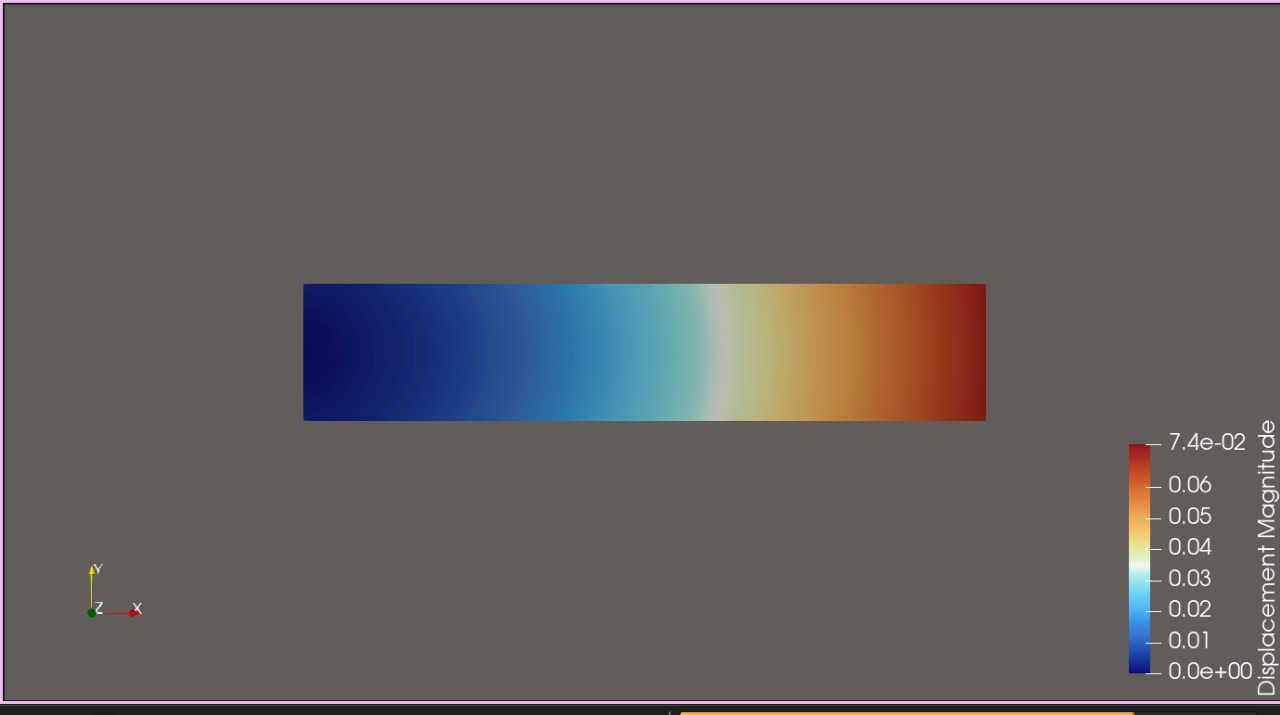
   